# Loan Mortgage House
## Table of contents
1. Introduction
2. Preprocessing Data
3. Data and Methods
4. Exploratory Data Analysis (EDA)
5. Model Implementation

## 1. Introduction
Mortgages are a popular financial product that enables people to buy their own homes. Mortgages allow individuals to borrow money against the value of their homes and repay it over a fixed period, usually 10 to 30 years. In recent years, the mortgage industry has seen significant growth, and lenders have become more competitive in their offerings to attract borrowers.
<br/>
In this data science project, we will explore a dataset related to how much money a person can get from a mortgage on their home. The primary objective of this project is to build a model that predicts the amount that customers can borrow based on the other features in the dataset. This model can help mortgage lenders make more informed decisions about lending money to customers, as well as provide valuable insights into the factors that influence mortgage borrowing.
<br/>
We will begin our analysis by exploring the dataset and identifying any trends or patterns in the data. We will also perform feature engineering to extract additional information from the existing features and prepare the data for modeling. Next, we will develop and train several machine learning models to predict the amount that customers can borrow based on the other features in the dataset. Finally, we will evaluate the performance of these models and select the best-performing model for deployment.
<br/>
Overall, this project aims to provide insights into the mortgage industry and develop a useful model that can assist lenders in making informed decisions about mortgage lending.

## 2. Preprocessing Data

In [1]:
import matplotlib.pyplot as plt
import pyarrow as pa
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Tuple
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
def getting_data(csv_file_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_file_path, engine='pyarrow', dtype_backend='pyarrow')


data = getting_data('data/final_house_loan.csv')

In [3]:
def identifying_threshold(sr: pd.Series) -> Tuple[float, float]:
    q1 = sr.quantile(0.25)
    q3 = sr.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    return lower_bound, upper_bound


def removing_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    lower_bound, upper_bound = identifying_threshold(df[col])
    return df[(df[col] > lower_bound) | (df[col] < upper_bound)]


def preprocessing_data(df: pd.DataFrame) -> pd.DataFrame:
    # Impute median "Income (USD)" by "Property Location"
    df['Income (USD)'] = df.groupby('Property Location')['Income (USD)'].transform(lambda x: x.fillna(x.median()))

    # Remove outliers in "Income (USD)"
    df = removing_outliers(df, 'Income (USD)')

    # Change rows with empty string in "Income Stability" to "Medium"
    df['Income Stability'] = df['Income Stability'].transform(lambda x: 'Medium' if x == '' else x).astype(
        pd.ArrowDtype(pa.string()))

    # Change rows with empty string in "Property Location" to NaN
    df['Property Location'] = df['Property Location'].transform(lambda x: None if x == '' else x).astype(
        pd.ArrowDtype(pa.string()))

    # Dropping rows with columns have less missing values
    threshold = len(data) * 0.05
    missing_values = df.isna().sum()
    df.dropna(subset=df.columns[(missing_values > 0) & (missing_values <= threshold)], inplace=True)

    # # Remove outliers in "Property Age"
    df = removing_outliers(df, 'Property Age')

    # Remove outliers in "Property Price"
    df = removing_outliers(df, 'Property Price')

    # # Remove outliers in "Loan Sanction Amount (USD)"
    df = removing_outliers(df, 'Loan Sanction Amount (USD)')

    # Dropping duplicates
    df = df.drop_duplicates()

    # Changing "Age" type to uint8
    df['Age'] = df['Age'].astype(pd.ArrowDtype(pa.uint8()))

    return df


data = preprocessing_data(data.copy())

## 3. Data and Methods
As a company, we have access to a dataset ([source](https://data.world/datasets/mortgage)):

**Information in the Dataset**
- "Gender" - Gender of the borrower ('F', 'M')
- "Age" - Age of the customer applying for a loan
- "Income (USD)" - Customer's income in USD
- "Income Stability" - The level of customer's income stability ('Low', 'High', 'Medium')
- "Property Age" - Life expectancy of the house in days
- "Property Location" - Location of the house ('Rural', 'Urban', 'Semi-Urban')
- "Property Price" - The value of the house in USD
- "Loan Sanction Amount (USD)" - Amount that customers can borrow in USD

**Remarks on the data:**<br>
The dataframe contains 47261 rows and 8 columns, with no missing values or duplicate rows. All the numeric columns is positive number. To prevent the skewed data during analysis, we removed outliers.

**Methods**<br>
Our exploratory data analysis involved various methodologies, including data cleaning, data visualization, statistical analysis, and machine learning algorithms. To clean the data, we used Pandas to handle missing values, and outliers, and transform variables as necessary. We also used Scikit-learn tools, such as PolynomialFeatures, to prepare the data for machine learning algorithms. For visualization, we employed Matplotlib and Seaborn to create various plots, including barplots, lineplots, and heatmaps, to identify patterns and relationships. For machine learning, we implemented Linear Regression.

## 4. Exploratory Data Analysis (EDA)

In [4]:
# Dataframe with number type only
num = data.select_dtypes(exclude=['string'])

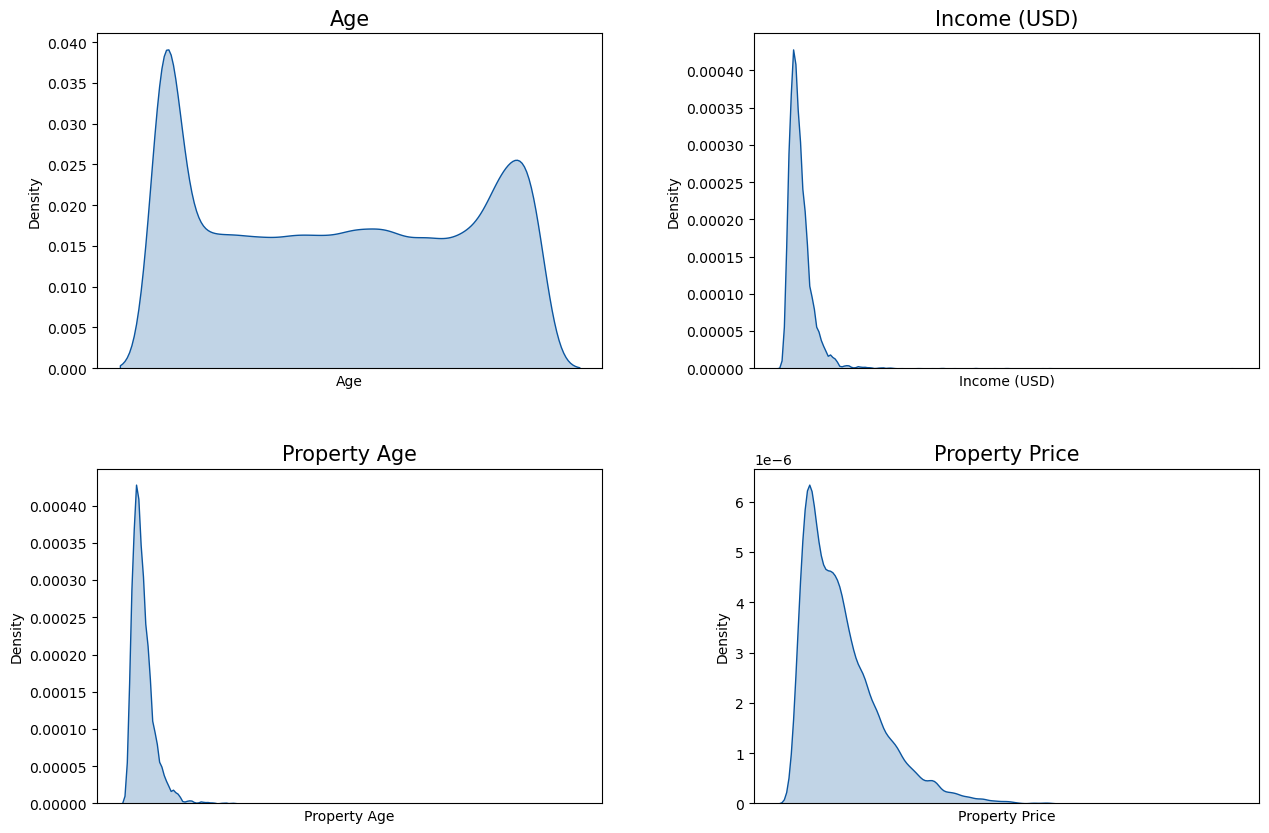

In [5]:
def plot_distribution(df: pd.DataFrame) -> None:
    sns.set_palette('Blues_r')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xticks([])

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.show()


plot_distribution(num)

In [6]:
data.describe()

,Age,Income (USD),Property Age,Property Price,Loan Sanction Amount (USD)
count,47261.0,47261.0,47261.0,47261.0,47261.0
mean,40.004803,2586.366797,2586.335947,135091.097948,46474.765702
std,16.08723,1557.556941,1557.618204,94587.668492,32543.778312
min,18.0,372.7,370.7,7859.62,254.586578
25%,25.0,1653.73,1652.82,62504.08,21775.599375
50%,40.0,2245.46,2244.81,113093.6,38819.359108
75%,55.0,3128.51,3128.24,181954.63,62576.176549
max,65.0,54662.75,54647.75,1077966.73,366131.165218


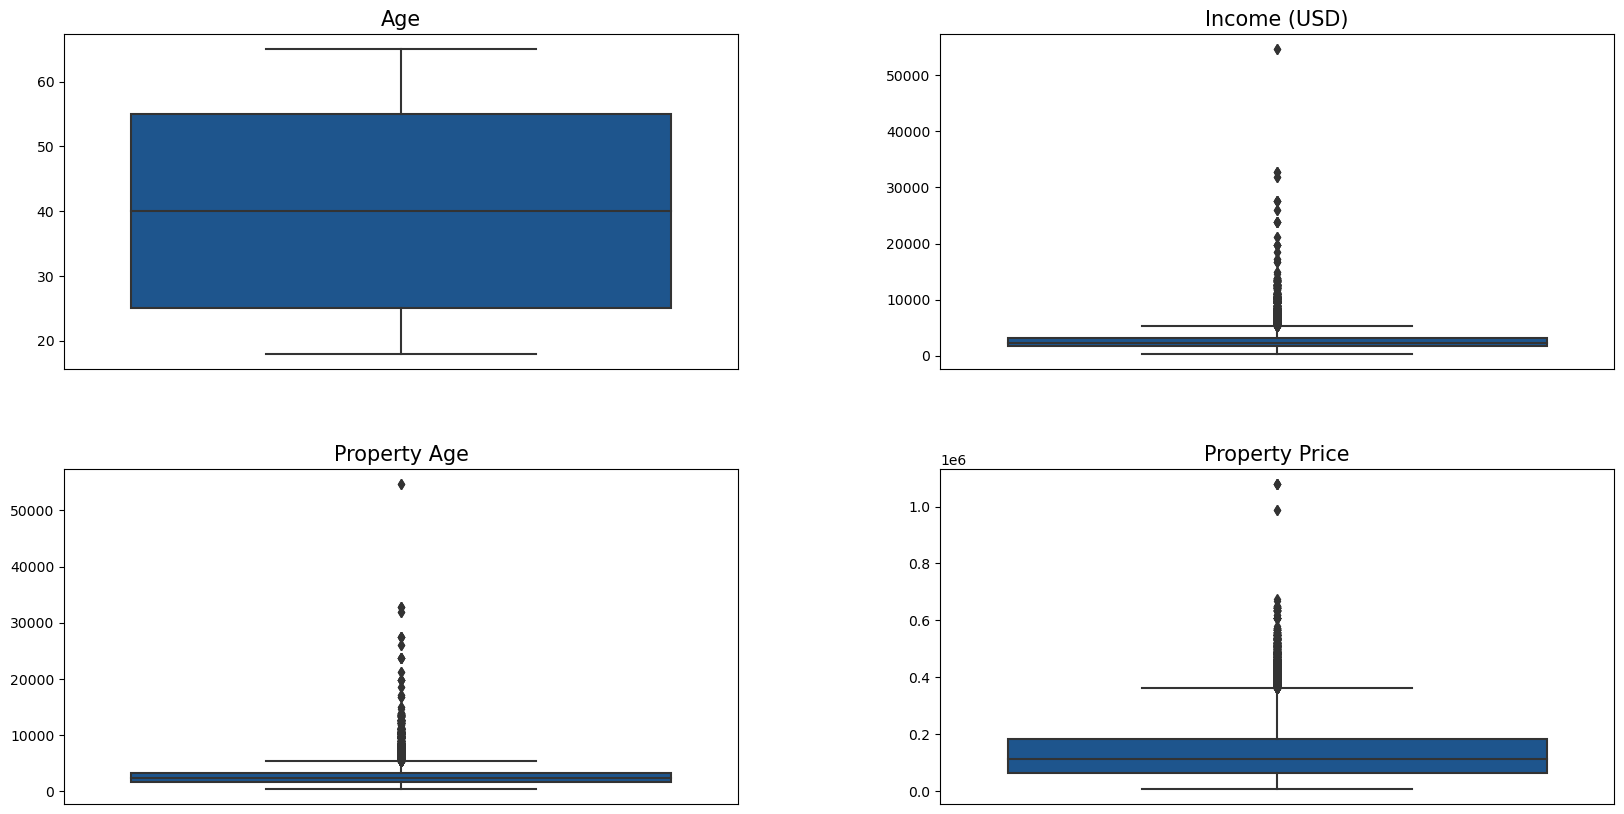

In [7]:
def plot_boxplot(df: pd.DataFrame) -> None:
    sns.set_palette('Blues_r')
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.boxplot(df[col], ax=ax)
        ax.set_title(col, fontsize=15)
        ax.set_xticks([])

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.show()


plot_boxplot(num)

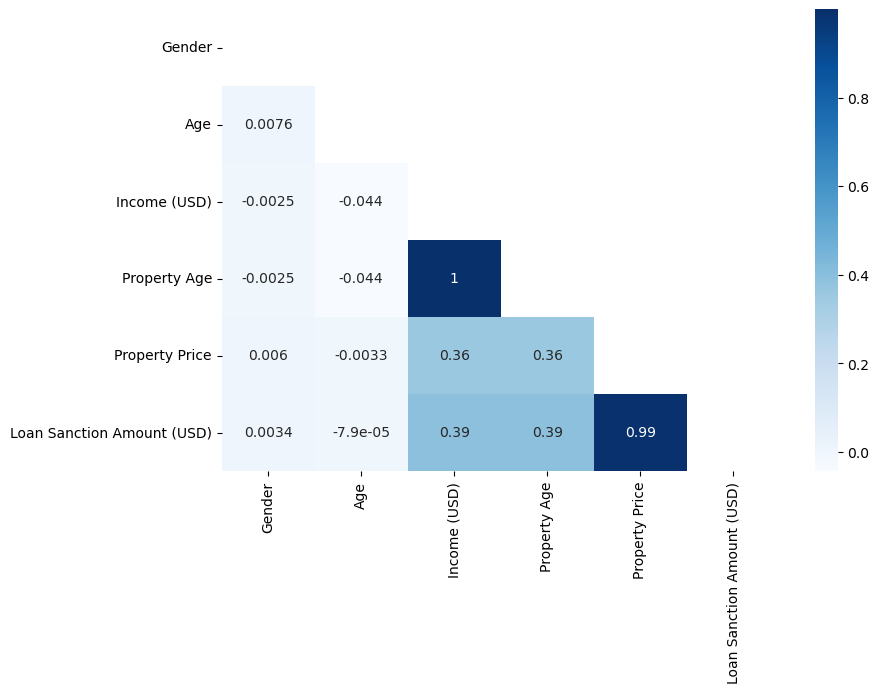

In [8]:
def plot_correlation(df: pd.DataFrame) -> None:
    corr = df.corr()

    plt.figure(figsize=(9, 6))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, annot=True, cmap='Blues', mask=mask)

    plt.show()


data_gender = data.copy()
data_gender['Gender'] = data_gender['Gender'].map({'M': 1, 'F': 0}).astype(pd.ArrowDtype(pa.uint8()))
plot_correlation(data_gender.select_dtypes(exclude=['string']))

### 4.1. What is the most common house location by age group?
By identifying the most common house location in each age group, consulting programs to each age group can be developed. In addition, this can provide useful information for planning resources and forecasting future needs.

In [9]:
def adding_age_group(df: pd.DataFrame) -> pd.DataFrame:
    df['Age Group'] = pd.cut(df['Age'], bins=[17, 30, 42, 54, 65],
                             labels=['18-30', '31-42', '43-54', '55-65'])
    return df


data_with_age_group = adding_age_group(data.copy())

In [10]:
def location_by_age_group(df: pd.DataFrame) -> None:
    print('Table 1. The most common house location by age group')
    age_group = df.groupby(['Age Group', 'Property Location']).size().reset_index(name='counts')

    pivot_table = pd.pivot_table(age_group,
                                 values='counts',
                                 index=['Property Location'],
                                 columns=['Age Group']).rank(ascending=False, axis=0)

    display(pivot_table.style.format('{:.0f}').background_gradient(cmap='Blues_r', axis=1).applymap(
        lambda x: 'background-color: mediumturquoise' if x == 1 else ''))


location_by_age_group(data_with_age_group.copy())

Table 1. The most common house location by age group


Age Group,18-30,31-42,43-54,55-65
Property Location,,,,
Rural,2,1,2,2
Semi-Urban,1,2,1,1
Urban,3,3,3,3


According to the table, the green color indicates the most frequent location by age group. Based on the data, we can conclude the following:
- **"Semi-Urban" is the most common house location across all age groups except for the 31-42 age group**, where "Rural" is the most common.
- **"Rural" is the second most common house location across all age groups except for the 31-42 age group**, where "Semi-Urban" is the second most common.
- **"Urban" is the third most common house location across all age groups**

We can also visualise the count of house location highlighting in green what has been recognized as the most frequent of house location.

Figure 1: Count house location by age group.


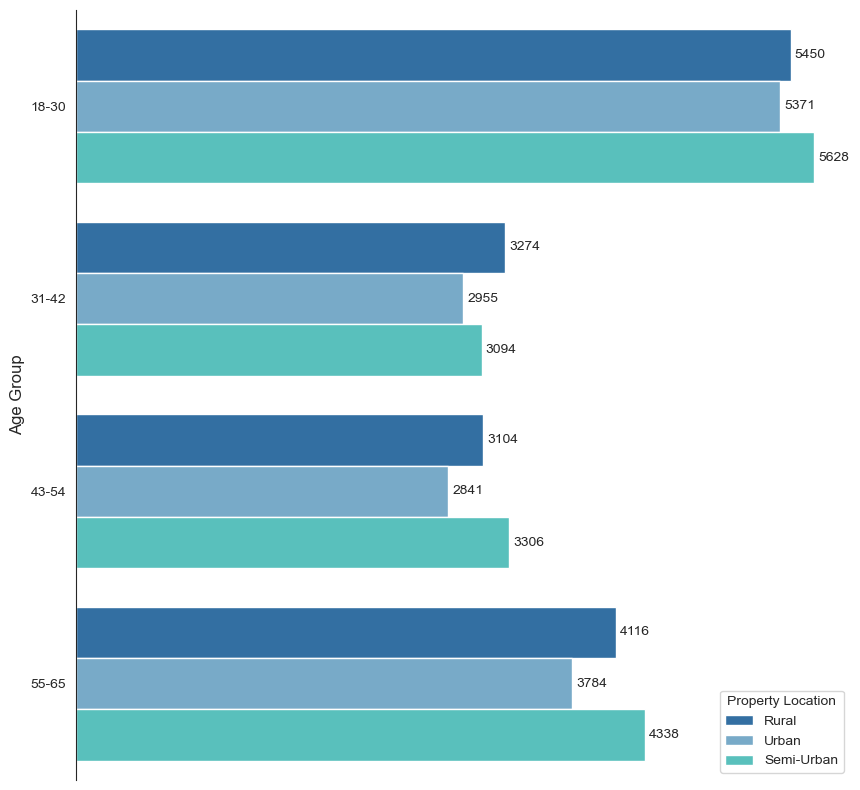

In [11]:
def plot_count_house_location(df: pd.DataFrame) -> None:
    print('Figure 1: Count house location by age group.')
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 10))

    unique_locations = df['Property Location'].unique()

    blues = sns.color_palette('Blues', n_colors=len(unique_locations))
    custom_palette = ['mediumturquoise' if location == 'Semi-Urban'
                      else blues[len(unique_locations) - 1 - i]
                      for i, location in enumerate(unique_locations)]

    sns.countplot(y='Age Group',
                  hue='Property Location',
                  order=df['Age Group'].sort_values().unique(),
                  palette=custom_palette,
                  data=df)

    for bar in ax.patches:
        width = bar.get_width()
        x = width
        y = bar.get_y() + bar.get_height() / 2
        label = f"{width:.0f}"
        ax.annotate(label, (x, y),
                    ha='left', va='center',
                    xytext=(3, 0), fontsize=10,
                    textcoords='offset points'
                    )

    sns.despine(bottom=True)
    plt.ylabel('Age Group', fontsize=12)
    plt.xlabel('')
    plt.xticks([])

    plt.show()


plot_count_house_location(data_with_age_group.copy())

### 4.2. Explore the effect of the level of customer’s income stability on the location of the house

Figure 2: Location ratio by Income Stability.


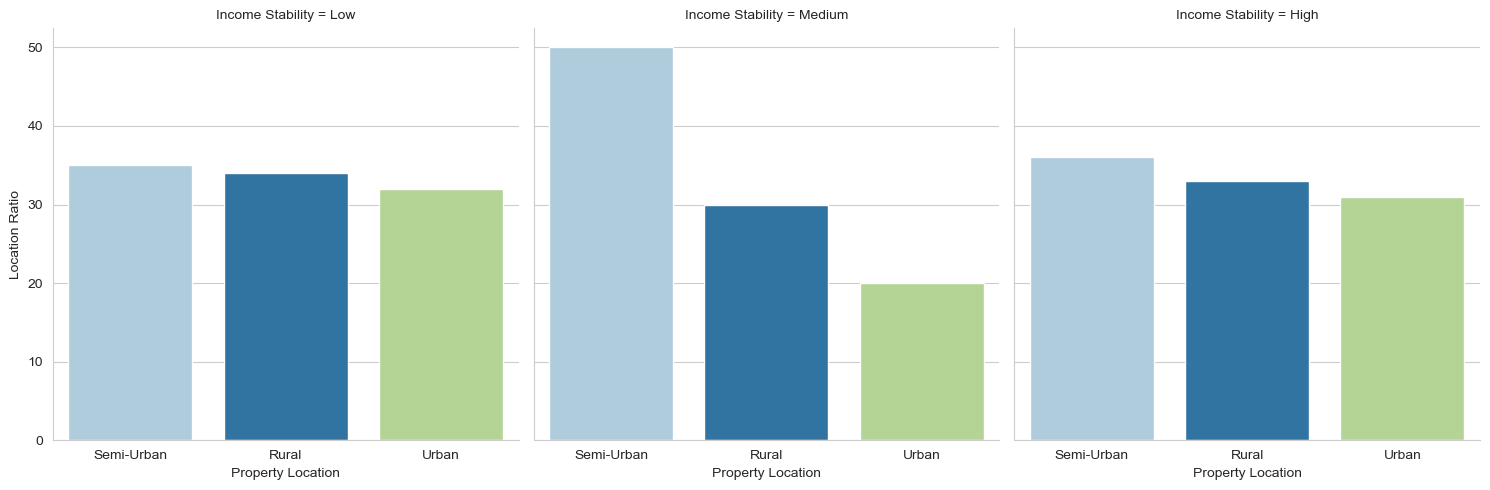

In [12]:
def plot_location_ratio_by_income_stability(df: pd.DataFrame) -> None:
    data_low_income = data[data['Income Stability'].values == 'Low']
    table_1 = data_low_income['Property Location'].value_counts(normalize=True).mul(100).round().reset_index(
        name='Location Ratio').rename(
        columns={'index': 'Property Location'})
    table_1['Income Stability'] = ['Low'] * len(table_1['Location Ratio'])

    data_medium_income = data[data['Income Stability'].values == 'Medium']
    table_2 = data_medium_income['Property Location'].value_counts(normalize=True).mul(100).round().reset_index(
        name='Location Ratio').rename(
        columns={'index': 'Property Location'})
    table_2['Income Stability'] = ['Medium'] * len(table_2['Location Ratio'])

    data_high_income = data[data['Income Stability'].values == 'High']
    table_3 = data_high_income['Property Location'].value_counts(normalize=True).mul(100).round().reset_index(
        name='Location Ratio').rename(
        columns={'index': 'Property Location'})
    table_3['Income Stability'] = ['High'] * len(table_3['Location Ratio'])

    data_income_stability = pd.concat([table_1, table_2, table_3])

    sns.set_style('whitegrid')
    sns.set_palette('Paired')

    sns.catplot(data=data_income_stability,
                x='Property Location',
                y='Location Ratio',
                col='Income Stability',
                kind='bar')

    plt.show()


print('Figure 2: Location ratio by Income Stability.')
plot_location_ratio_by_income_stability(data.copy())

## 6. Model Implementation

### 6.1. Feature Engineering

In [13]:
def normalized_data(df: pd.DataFrame) -> pd.DataFrame:
    normalized = pd.get_dummies(df.loc[:, ['Gender', 'Income Stability', 'Property Location']])
    normalized = pd.concat([normalized, df.select_dtypes(exclude=['string'])], axis=1)
    return normalized


standardized_data = normalized_data(data.copy())
standardized_data.head()

,Gender_F,Gender_M,Income Stability_High,Income Stability_Low,Income Stability_Medium,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Age,Income (USD),Property Age,Property Price,Loan Sanction Amount (USD)
0,True,False,False,True,False,True,False,False,19,1641.25,1651.25,59641.82,21026.420753
1,False,True,False,True,False,False,False,True,29,1989.71,1990.71,179858.51,60595.183366
2,True,False,False,True,False,True,False,False,37,1849.91,1856.91,117297.62,39181.648002
3,False,True,True,False,False,True,False,False,65,2735.18,2747.18,354417.72,128497.710865
4,True,False,True,False,False,False,False,True,62,4741.78,4740.78,82049.80,39386.919336


### 6.2. Apply model

In [14]:
def prepare_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    columns = df.columns.tolist()
    columns.remove('Loan Sanction Amount (USD)')

    X = df.loc[:, columns]
    y = df.loc[:, 'Loan Sanction Amount (USD)']

    return X, y


X, y = prepare_data(standardized_data.copy())

In [15]:
def split_data(X: pd.DataFrame, y: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(X, y)

In [16]:
def build_model(X_train: pd.DataFrame, y_train: pd.DataFrame) -> LinearRegression:
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model


model = build_model(X_train, y_train)
predictions = model.predict(X_train)
print(f'MAE of the model on the training set: {mean_absolute_error(y_train, predictions)}')
predictions = model.predict(X_test)
print(f'MAE of the model on the test set: {mean_absolute_error(y_test, predictions)}')

print(f'Coefficients:\n{model.coef_}')
print(f'Intercept: {model.intercept_}')

MAE of the model on the training set: 125.43613714938351
MAE of the model on the test set: 125.29268335500849
Coefficients:
[ 1.24822421e+02 -1.24822421e+02  3.72865670e+03 -7.43214671e+03
  3.70349001e+03  1.28470923e+02 -1.44158054e+02  1.56871312e+01
 -7.93891812e+01  5.32093634e-01  4.95511174e-01  3.36130460e-01]
Intercept: 8022.500598893173


In [17]:
def build_pipeline(X, y) -> Pipeline:
    poly_model = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
    poly_model.fit(X, y)
    return poly_model


poly_model = build_pipeline(X_train, y_train)
predictions = poly_model.predict(X_train)
print(f'MAE of the model on the training set: {mean_absolute_error(y_train, predictions)}')
predictions = poly_model.predict(X_test)
print(f'MAE of the model on the test set: {mean_absolute_error(y_test, predictions)}')

MAE of the model on the training set: 142.85581484799832
MAE of the model on the test set: 144.5332465507514
